##### https://docs.mdanalysis.org/stable/documentation_pages/analysis/rms.html#MDAnalysis.analysis.rms.RMSD

##### https://userguide.mdanalysis.org/stable/examples/transformations/center_protein_in_box.html#Doing-all-this-on-the-fly
##### https://userguide.mdanalysis.org/stable/trajectories/transformations.html

In [1]:
from pathlib import Path
from tqdm import tqdm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import nglview as nv
import MDAnalysis as mda
from MDAnalysis.analysis import rms, diffusionmap, align
from MDAnalysis.analysis.distances import dist
from MDAnalysis.analysis.hydrogenbonds.hbond_analysis import HydrogenBondAnalysis as HBA


/home/media/data2/user_home/dbsejrgus226/miniconda3/envs/MD/lib/python3.8/site-packages/Bio/Application/__init__.py:40: BiopythonDeprecationWarning: The Bio.Application modules and modules relying on it have been deprecated.

Due to the on going maintenance burden of keeping command line application
wrappers up to date, we have decided to deprecate and eventually remove these
modules.

We instead now recommend building your command line and invoking it directly
with the subprocess module.
  warnings.warn(


In [2]:
from MDAnalysis.transformations import wrap
from MDAnalysis import transformations as trans

In [3]:
# 1,2 and 3 과정을 한번에 하기

md_universe = mda.Universe(str("./240911_Final_topology_50ns_PME_1.pdb"), str("./240911_Final_trajectory_50ns_PME_1.xtc"))

protein = md_universe.select_atoms("protein or resname UNK")
not_protein = md_universe.select_atoms("not protein")

transforms = [trans.unwrap(protein),
              trans.center_in_box(protein),
              trans.wrap(not_protein)]

md_universe.trajectory.add_transformations(*transforms)

/home/media/data2/user_home/dbsejrgus226/miniconda3/envs/MD/lib/python3.8/site-packages/MDAnalysis/topology/PDBParser.py:287: UserWarning: PDB file is missing resid information.  Defaulted to '1'
  warnings.warn("PDB file is missing resid information.  "


In [4]:
# for 문을 돌리되 writting 하지 않을 경우
# for ts in md_universe_1.trajectory:
#     pass

In [5]:
with mda.Writer("20240913_transformed_trajectory_rank1_3_test.xtc", md_universe.atoms.n_atoms) as W:
    for ts in tqdm(md_universe.trajectory, desc="Writing trajectory..."):
        W.write(md_universe.atoms)


Writing trajectory...: 100%|██████████| 500/500 [00:16<00:00, 30.37it/s]


In [6]:
transformed_universe = mda.Universe(str("./240911_Final_topology_50ns_PME_1.pdb"), str("./20240913_transformed_trajectory_rank1_3_test.xtc"))

/home/media/data2/user_home/dbsejrgus226/miniconda3/envs/MD/lib/python3.8/site-packages/MDAnalysis/coordinates/XDR.py:241: UserWarning: Reload offsets from trajectory
 ctime or size or n_atoms did not match
  warnings.warn("Reload offsets from trajectory\n "


In [7]:
# Set trajectory pointer to first frame as reference
transformed_universe.trajectory[0]

< Timestep 0 with unit cell dimensions [86.20452 86.20452 86.20452 90.      90.      90.     ] >

In [8]:
# in_memory=True is needed to actually modify the loaded trajectory
# if the trajectory is too big for memory, one can write out the aligned trajectory and reload it into a new universe
alignment_1 = align.AlignTraj(
    mobile=transformed_universe, reference=transformed_universe, select="protein", in_memory=True
)
alignment_1.run()

In [9]:
def rmsd_for_atomgroups(universe, selection1, selection2=None):
    """Calulate the RMSD for selected atom groups.

    Parameters
    ----------
    universe: MDAnalysis.core.universe.Universe
        MDAnalysis universe.
    selection1: str
        Selection string for main atom group, also used during alignment.
    selection2: list of str, optional
        Selection strings for additional atom groups.

    Returns
    -------
    rmsd_df: pandas.core.frame.DataFrame
        DataFrame containing RMSD of the selected atom groups over time.
    """

    universe.trajectory
    ref = universe
    rmsd_analysis = rms.RMSD(universe, ref, select=selection1, groupselections=selection2)
    rmsd_analysis.run()

    columns = [selection1, *selection2] if selection2 else [selection1]
    #print(rmsd_analysis.results)
    #print(rmsd_analysis)
    rmsd_df = pd.DataFrame(np.round(rmsd_analysis.results.rmsd[:, 2:], 2), columns=columns)
    rmsd_df.index.name = "time"
    return rmsd_df

In [10]:
rmsd_1 = rmsd_for_atomgroups(transformed_universe, "backbone", ["protein", "resname UNK"])

In [11]:
rmsd_1.rename(columns={"resname UNK": "rank_1_ligand"}, inplace=True)

In [12]:
rmsd_1.to_csv("./20240913_df_rank1_wrap_3_rmsd.csv", index=False)

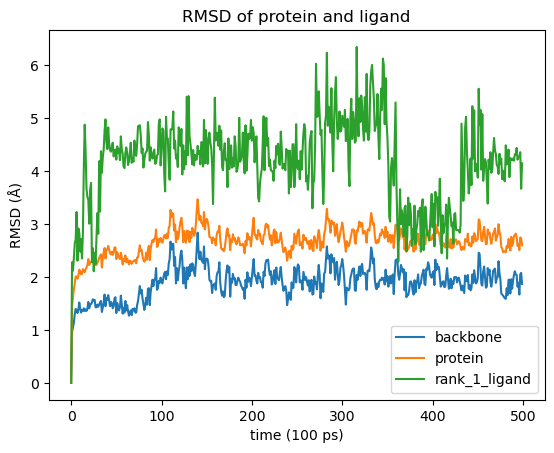

In [13]:
rmsd_1.plot(title="RMSD of protein and ligand")
plt.xlabel("time (100 ps)")
plt.ylabel("RMSD (Å)");
plt.savefig("20240913_final_rank1_rmsd_for50ns_wrap_3_results") 

In [14]:
# identfy the box size

box_vectors = md_universe_1.dimensions
print("박스 크기:", box_vectors)

NameError: name 'md_universe_1' is not defined

In [11]:
all_position = md_universe_1.atoms.positions

In [12]:
min_coords = np.min(all_position, axis=0)
max_coords = np.max(all_position, axis=0)

In [13]:
dimensions = max_coords - min_coords

In [14]:
print(f"복합체의 크기: X = {dimensions[0]:.2f} Å, Y = {dimensions[1]:.2f} Å, Z = {dimensions[2]:.2f} Å")

복합체의 크기: X = 105.10 Å, Y = 112.53 Å, Z = 98.53 Å


In [4]:
import numpy as np

def wrap_coordinates(coordinates, box_size):
    """
    좌표를 주기적 경계 조건(PBC)을 적용하여 랩핑하는 함수.

    Parameters:
    - coordinates: 원자의 좌표 배열 (N x 3, 여기서 N은 원자의 수)
    - box_size: 시뮬레이션 상자의 크기 (Lx, Ly, Lz)

    Returns:
    - wrapped_coords: 랩핑된 좌표 배열 (N x 3)
    """

    wrapped_coords = np.mod(coordinates, box_size)
    return wrapped_coords

# 예시 데이터
# 원자의 좌표 (N x 3 형태)
coordinates = np.array([[11.0, 4.0, -2.0], 
                        [5.0, 12.0, 8.0], 
                        [-1.0, -6.0, 14.0]])

# 시뮬레이션 상자의 크기 (Lx, Ly, Lz)
box_size = np.array([10.0, 10.0, 10.0])

# 좌표 랩핑
wrapped_coords = wrap_coordinates(coordinates, box_size)

print("원래 좌표:")
print(coordinates)
print("\n랩핑된 좌표:")
print(wrapped_coords)


원래 좌표:
[[11.  4. -2.]
 [ 5. 12.  8.]
 [-1. -6. 14.]]

랩핑된 좌표:
[[1. 4. 8.]
 [5. 2. 8.]
 [9. 4. 4.]]
